In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
base_path = "/content/drive/MyDrive/ML4CV_projectwork/"

In [3]:
import os
import torch
import numpy as np
import random

In [4]:
def fix_random(seed):
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)  

In [5]:
LEARNING_RATE = 1e-4
MOMENTUM = 0.99
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
NUM_EPOCHS = 25
NUM_WORKERS = 2
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "./BrainTumor/train/imgs"
TRAIN_MASK_DIR = "./BrainTumor/train/mask"
VALID_IMG_DIR = "./BrainTumor/valid/imgs"
VALID_MASK_DIR = "./BrainTumor/valid/mask"
TEST_IMG_DIR = "./BrainTumor/test/"

In [6]:
!nvidia-smi

Mon Jan 24 11:58:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    32W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset and preprocessing

In [7]:
!unzip -qq  "/content/drive/MyDrive/ML4CV_projectwork/BrainTumor.zip"

In [8]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader

"""
Class to load and transform images with corresponding masks from the dataset
"""
class BrainTumorDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, index):
    img_path = os.path.join(self.image_dir, self.images[index])
    mask_path = os.path.join(self.mask_dir, self.images[index].replace("jpg", "png"))

    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
    mask[mask > 0.0] = 1.0

    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]
    
    return image, mask

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensor

train_transform = A.Compose(
    [
     A.Resize(height = IMAGE_HEIGHT, width = IMAGE_WIDTH),
     A.RandomRotate90(p = 0.3),
     A.HorizontalFlip(p = 0.5),
     A.VerticalFlip(p = 0.2),
     #A.InvertImg(p = 0.5),
     A.Normalize(
         mean = [0.0, 0.0, 0.0],
         std = [1.0, 1.0, 1.0],
         max_pixel_value = 255.0,
     ),
     ToTensor(),
    ],
)

valid_transform = A.Compose(
    [
     A.Resize(height = IMAGE_HEIGHT, width = IMAGE_WIDTH),
     A.Normalize(
         mean = [0.0, 0.0, 0.0],
         std = [1.0, 1.0, 1.0],
         max_pixel_value = 255.0,
     ),
     ToTensor(),
    ],
)

test_transform = A.Compose(
    [
     A.Resize(height = IMAGE_HEIGHT, width = IMAGE_WIDTH),
     ToTensor(),
    ],
)

In [10]:
def get_loaders(
    train_img_dir,
    train_mask_dir,
    valid_img_dir,
    valid_mask_dir,
    batch_size,
    train_transform,
    valid_transform,
    num_workers = 4,
    pin_memory = True,
  ):

  train_ds = BrainTumorDataset(
      image_dir = train_img_dir,
      mask_dir = train_mask_dir,
      transform = train_transform,
  )

  train_loader = DataLoader(
      train_ds,
      batch_size = batch_size,
      num_workers = num_workers,
      pin_memory = pin_memory,
      shuffle = True,
  )

  valid_ds = BrainTumorDataset(
      image_dir = valid_img_dir,
      mask_dir = valid_mask_dir,
      transform = valid_transform,
  )

  valid_loader = DataLoader(
      valid_ds,
      batch_size = batch_size,
      num_workers = num_workers,
      pin_memory = pin_memory,
      shuffle = True,
  )

  return train_ds, valid_ds, train_loader, valid_loader

train_ds, valid_ds, train_loader, valid_loader = get_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VALID_IMG_DIR,
    VALID_MASK_DIR,
    BATCH_SIZE,
    train_transform,
    valid_transform,
    NUM_WORKERS,
    PIN_MEMORY,
)

In [11]:
# trying to  print the length of the train_data_tensor
print(f'Samples -> Train = {len(train_ds)} - Val = {len(valid_ds)}')

Samples -> Train = 700 - Val = 100


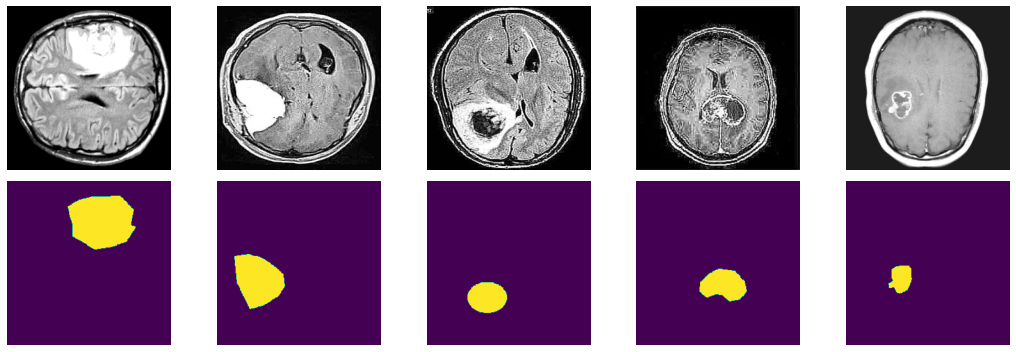

In [85]:
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

def show_grid(dataset):
    """
    Shows a grid with random images with correspondin masks taken from the dataset.

    Args:
        dataset: the dataset containing the images and masks
    """
    fig = plt.figure(figsize=(15, 5))
    indices_random = np.random.randint(5, size=5, high=len(dataset))

    for count, idx in enumerate(indices_random):
        image, mask = train_ds[idx]
        fig.add_subplot(2, 5, count + 1)
        plt.imshow(ToPILImage()(image))
        plt.axis("off")
        fig.add_subplot(2, 5, 5 + count + 1)
        plt.imshow(ToPILImage()(mask))
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

show_grid(train_ds)

# Model Definition
The model used is a variation of the U-Net, represented below, that implements the attention mechanism in figure below on the tensor we are going to concatenate during the upsampling phase.

This attention mechanism consists in applying two distinct 1×1 convs respectively on skip connecion and the tensor at the lower scale, then sum the two and apply a ReLU activation and again another 1×1 conv followed by a sigmoid function to have values between [0,1]. Finally these values are multiplied by the tensor coming from the skip connection in order to highligh more salient points.

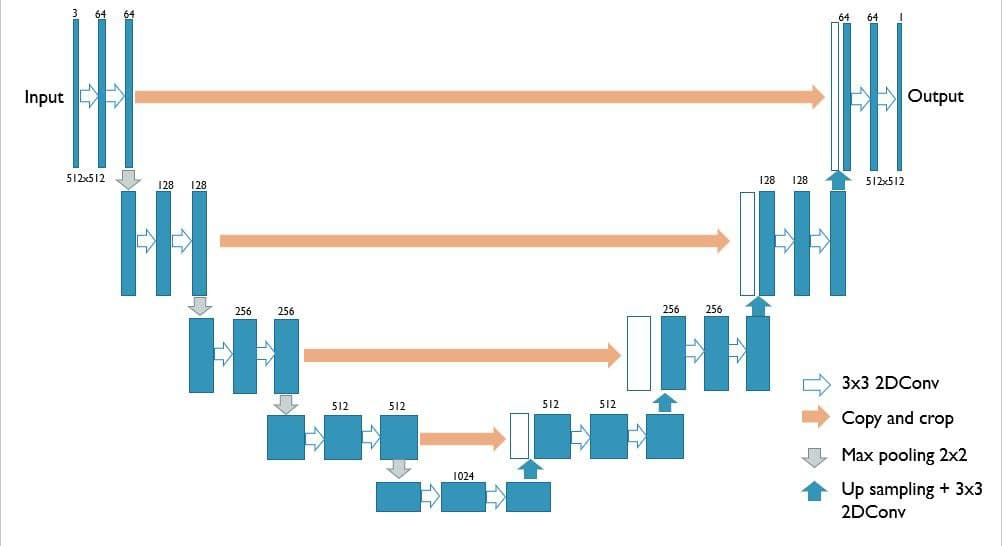

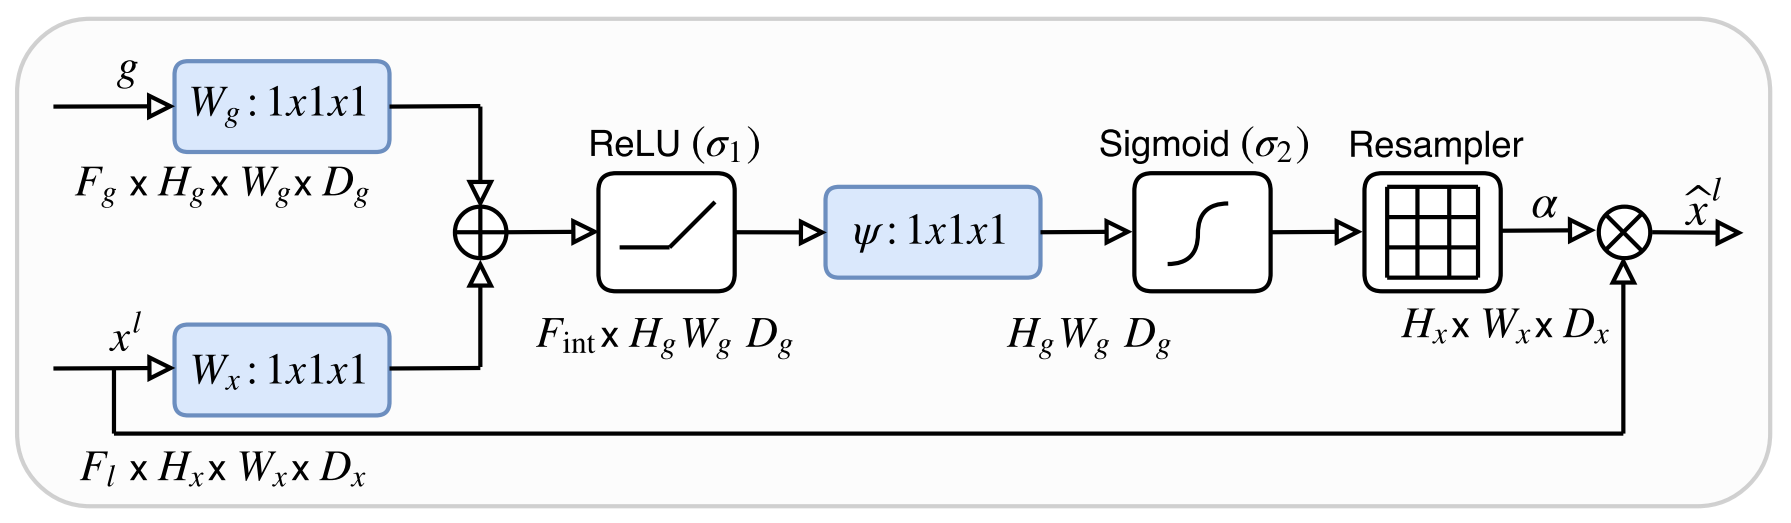

In [13]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

"""
Class that define the two 3x3 convs to apply at each scale
"""
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()

    self.conv = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
    )

  def forward(self, x):
    return self.conv(x)

"""
Class that implements the attention mechanism
"""
class AttentionBlock(nn.Module):
  def __init__(self, F_g, F_l, F_int):
    super(AttentionBlock, self).__init__()

    self.W_g = nn.Sequential(
      nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=False),
      nn.BatchNorm2d(F_int),
    )
      
    self.W_x = nn.Sequential(
      nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=False),
      nn.BatchNorm2d(F_int),
    )

    self.psi = nn.Sequential(
      nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=False),
      nn.BatchNorm2d(1),
    )
      
    self.relu = nn.ReLU(inplace=True)

    self.sigmoid = nn.Sigmoid()
      
  def forward(self, g, x):
      g1 = self.W_g(g)
      x1 = self.W_x(x)
      alpha = self.sigmoid(self.psi(self.relu(g1 + x1)))

      return x * alpha

"""
Class that implments the logic of U-Net with and without attention block,
we can select the second setting the attention parameter to True
"""
class UNET(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, attention=False):
    super(UNET, self).__init__()

    self.doubleConvs_down = nn.ModuleList()
    self.doubleConvs_up = nn.ModuleList()
    self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.upConvs = nn.ModuleList()

    self.attention = attention
    if self.attention:
      self.attentionBlocks = nn.ModuleList()

    features = [64, 128, 256, 512]

    # Down convolutions: [in_channels, 64] -> [64, 128] -> [128, 256] -> [256, 512]
    for feature in features:
      self.doubleConvs_down.append(DoubleConv(in_channels, feature))
      in_channels = feature
    
    # -> [512, 1024]
    self.bottlenek = DoubleConv(features[-1], 2*features[-1]) 

    # Up convolutions: [1024, 512] -> [512, 256] -> [256, 128] -> [128, 64]
    for feature in reversed(features):
      self.upConvs.append(nn.ConvTranspose2d(2*feature, feature, kernel_size=2, stride=2))
      self.doubleConvs_up.append(DoubleConv(2*feature, feature))
      if self.attention:
        self.attentionBlocks.append(AttentionBlock(feature, feature, feature//2))

    # -> [64, out_channels]
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1, stride=1, padding=0) 
  
  def forward(self, x):
    skip_connections = []

    for dc_down in self.doubleConvs_down:
      x = dc_down(x)
      skip_connections.append(x)
      x = self.Maxpool(x)

    x = self.bottlenek(x)

    for i, skip_connection in enumerate(reversed(skip_connections)):
      x = self.upConvs[i](x)

      # Due to 2d conv the non-divisible sizes are cropped and so
      # doesn't match durind the upsampling, must be resized
      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])

      if self.attention:
        skip_connection = self.attentionBlocks[i](x, skip_connection)
      
      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.doubleConvs_up[i](concat_skip)
    
    return self.final_conv(x)

In [14]:
def test_dimensions():
  x = torch.randn((3, 3, 161, 161))
  model = UNET(in_channels = 3, out_channels = 1, attention=True)
  pred = model(x)
  print(x.shape)
  print(pred.shape)
  assert pred.shape[2:] == x.shape[2:]

test_dimensions()

torch.Size([3, 3, 161, 161])
torch.Size([3, 1, 161, 161])


# Train and evaluation functions

In [15]:
from tqdm import tqdm

def train_fn(loader, model, optimizer, loss_fn, scaler):
  """
  Function to train the model

  Args:
      loader: train images/masks loader
      model: model to train
      optimizer: choosen optimizer
      loss_fn: choosen loss function
      scaler: gradient scaler
  """

  loop = tqdm(loader)

  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(DEVICE)
    targets = targets.float().to(DEVICE)
  
    # forward
    with torch.cuda.amp.autocast():
      predictions = model(data)
      loss = loss_fn(predictions, targets)

    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    #update tqdm loop
    loop.set_postfix(loss=loss.item())

In [16]:
def evaluate_metrics(loader, model, device="cuda"):
  """
  Function to evaluate the model against validation dataset

  Args:
      loader: validation images/masks loader
      model: model to validate
  """

  num_correct = 0
  num_pixels = 0
  dice = 0
  iou = 0
  model.eval()

  with torch.no_grad():
    for x, y, in loader:
      x = x.to(device)
      y = y.to(device)
      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()
      num_correct += (preds == y).sum()
      num_pixels += torch.numel(preds)
      intersection = (preds * y).sum()  #TP
      dice += (2*intersection) / ((preds + y).sum() + 1e-8) # 2*TP / (2*TP + FP + TN)
      union = (preds + y).sum() - intersection
      iou += intersection / (union + 1e-8)  # TP / (TP + FP + TN)
      
  
  accuracy = num_correct/num_pixels*100

  dice_score = dice/len(loader)

  iou_score = iou/len(loader)

  print(
      f"Metrics:\tAccuracy: {accuracy:.2f}%\tDice score: {dice_score:.2f}\tIoU score: {iou_score:.2f}"
  )
  model.train()

  return accuracy.item(), dice_score.item(), iou_score.item()

In [17]:
def save_checkpoint(state, filename):
  """
  Function to save a checkpoint of the model configurations

  Args:
      state: dictionary of parameters of the model to save
      filename: file in which save the model configuration
  """
  print("=> Saving checkpoint")
  torch.save(state, filename)

def load_checkpoint(checkpoint, model):
  """
  Function to load a checkpoint of model configurations

  Args:
      checkpoint: dictionary of parameters of the model loaded
      model: model in which load configurations
  """
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])

# Training phase

In [18]:
model = None

### U-Net

In [ ]:
if model is not None:
  del model
  torch.cuda.empty_cache()

In [ ]:
model = UNET(in_channels = 3, out_channels = 1, attention=False).to(DEVICE)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) #torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scaler = torch.cuda.amp.GradScaler()

UNet_checkpoint = {
    "best_diceScore" : 0.0,
    "state_dict": model.state_dict(),
    "optimizer": optimizer.state_dict(),
}

UNet_metrics = {
    "accuracy_scores" : [],
    "dice_scores" : [],
    "iou_scores" : [],
}

In [ ]:
from torchsummary import summary
summary(model, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,728
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,864
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
        DoubleConv-7         [-1, 64, 512, 512]               0
         MaxPool2d-8         [-1, 64, 256, 256]               0
            Conv2d-9        [-1, 128, 256, 256]          73,728
      BatchNorm2d-10        [-1, 128, 256, 256]             256
             ReLU-11        [-1, 128, 256, 256]               0
           Conv2d-12        [-1, 128, 256, 256]         147,456
      BatchNorm2d-13        [-1, 128, 256, 256]             256
             ReLU-14        [-1, 128, 2

In [ ]:
if LOAD_MODEL:
  load_checkpoint(torch.load(os.path.join(base_path, "UNet.pth.tar")), model)
  _, UNet_checkpoint["best_diceScore"], _ = evaluate_metrics(valid_loader, model, device=DEVICE)

for epoch in range(NUM_EPOCHS):
  train_fn(train_loader, model, optimizer, loss_fn, scaler)

  # check accuracy
  accuracy, dice, iou = evaluate_metrics(valid_loader, model, device=DEVICE)
  UNet_metrics["accuracy_scores"].append(accuracy)
  UNet_metrics["dice_scores"].append(dice)
  UNet_metrics["iou_scores"].append(iou)

  # save model
  if dice > UNet_checkpoint["best_diceScore"]:
    save_checkpoint(UNet_checkpoint, os.path.join(base_path, "UNet.pth.tar"))
    UNet_checkpoint["best_diceScore"] = dice  

100%|██████████| 88/88 [00:18<00:00,  4.80it/s, loss=0.485]


Metrics:	Accuracy: 95.35%	Dice score: 0.27	IoU score: 0.17
=> Saving checkpoint


100%|██████████| 88/88 [00:18<00:00,  4.72it/s, loss=0.351]


Metrics:	Accuracy: 95.38%	Dice score: 0.22	IoU score: 0.14


100%|██████████| 88/88 [00:18<00:00,  4.66it/s, loss=0.337]


Metrics:	Accuracy: 95.22%	Dice score: 0.22	IoU score: 0.13


100%|██████████| 88/88 [00:18<00:00,  4.69it/s, loss=0.28]


Metrics:	Accuracy: 95.21%	Dice score: 0.23	IoU score: 0.14


100%|██████████| 88/88 [00:18<00:00,  4.74it/s, loss=0.299]


Metrics:	Accuracy: 95.37%	Dice score: 0.33	IoU score: 0.21
=> Saving checkpoint


100%|██████████| 88/88 [00:18<00:00,  4.71it/s, loss=0.241]


Metrics:	Accuracy: 95.65%	Dice score: 0.38	IoU score: 0.25
=> Saving checkpoint


100%|██████████| 88/88 [00:18<00:00,  4.70it/s, loss=0.202]


Metrics:	Accuracy: 96.27%	Dice score: 0.50	IoU score: 0.35
=> Saving checkpoint


100%|██████████| 88/88 [00:18<00:00,  4.71it/s, loss=0.205]


Metrics:	Accuracy: 96.26%	Dice score: 0.53	IoU score: 0.37
=> Saving checkpoint


100%|██████████| 88/88 [00:18<00:00,  4.70it/s, loss=0.162]


Metrics:	Accuracy: 96.54%	Dice score: 0.53	IoU score: 0.38


100%|██████████| 88/88 [00:18<00:00,  4.70it/s, loss=0.146]


Metrics:	Accuracy: 96.58%	Dice score: 0.56	IoU score: 0.41
=> Saving checkpoint


100%|██████████| 88/88 [00:18<00:00,  4.71it/s, loss=0.129]


Metrics:	Accuracy: 96.97%	Dice score: 0.65	IoU score: 0.50
=> Saving checkpoint


100%|██████████| 88/88 [00:18<00:00,  4.72it/s, loss=0.127]


Metrics:	Accuracy: 96.87%	Dice score: 0.65	IoU score: 0.50
=> Saving checkpoint


100%|██████████| 88/88 [00:18<00:00,  4.70it/s, loss=0.111]


Metrics:	Accuracy: 97.37%	Dice score: 0.71	IoU score: 0.56
=> Saving checkpoint


100%|██████████| 88/88 [00:18<00:00,  4.71it/s, loss=0.163]


Metrics:	Accuracy: 97.60%	Dice score: 0.75	IoU score: 0.61
=> Saving checkpoint


100%|██████████| 88/88 [00:18<00:00,  4.70it/s, loss=0.0963]


Metrics:	Accuracy: 97.06%	Dice score: 0.66	IoU score: 0.50


100%|██████████| 88/88 [00:18<00:00,  4.72it/s, loss=0.101]


Metrics:	Accuracy: 97.64%	Dice score: 0.75	IoU score: 0.61
=> Saving checkpoint


100%|██████████| 88/88 [00:18<00:00,  4.72it/s, loss=0.0863]


Metrics:	Accuracy: 97.20%	Dice score: 0.70	IoU score: 0.54


100%|██████████| 88/88 [00:18<00:00,  4.73it/s, loss=0.0876]


Metrics:	Accuracy: 97.47%	Dice score: 0.71	IoU score: 0.56


100%|██████████| 88/88 [00:18<00:00,  4.71it/s, loss=0.0643]


Metrics:	Accuracy: 97.44%	Dice score: 0.74	IoU score: 0.60


100%|██████████| 88/88 [00:18<00:00,  4.73it/s, loss=0.0605]


Metrics:	Accuracy: 97.93%	Dice score: 0.80	IoU score: 0.67
=> Saving checkpoint


100%|██████████| 88/88 [00:18<00:00,  4.72it/s, loss=0.076]


Metrics:	Accuracy: 97.88%	Dice score: 0.80	IoU score: 0.68
=> Saving checkpoint


100%|██████████| 88/88 [00:18<00:00,  4.72it/s, loss=0.0511]


Metrics:	Accuracy: 97.95%	Dice score: 0.81	IoU score: 0.68
=> Saving checkpoint


100%|██████████| 88/88 [00:18<00:00,  4.72it/s, loss=0.0703]


Metrics:	Accuracy: 97.97%	Dice score: 0.80	IoU score: 0.66


100%|██████████| 88/88 [00:18<00:00,  4.73it/s, loss=0.0608]


Metrics:	Accuracy: 97.41%	Dice score: 0.70	IoU score: 0.55


100%|██████████| 88/88 [00:18<00:00,  4.71it/s, loss=0.0466]


Metrics:	Accuracy: 97.69%	Dice score: 0.78	IoU score: 0.65


## Attention U-Net

In [19]:
if model is not None:
  del model
  torch.cuda.empty_cache()

In [20]:
model = UNET(in_channels = 3, out_channels = 1, attention=True).to(DEVICE)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) #torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scaler = torch.cuda.amp.GradScaler()

AttUNet_checkpoint = {
    "best_diceScore" : 0.0,
    "state_dict": model.state_dict(),
    "optimizer": optimizer.state_dict(),
}

AttUNet_metrics = {
    "accuracy_scores" : [],
    "dice_scores" : [],
    "iou_scores" : [],
}

In [ ]:
from torchsummary import summary
summary(model, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,728
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,864
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
        DoubleConv-7         [-1, 64, 512, 512]               0
         MaxPool2d-8         [-1, 64, 256, 256]               0
            Conv2d-9        [-1, 128, 256, 256]          73,728
      BatchNorm2d-10        [-1, 128, 256, 256]             256
             ReLU-11        [-1, 128, 256, 256]               0
           Conv2d-12        [-1, 128, 256, 256]         147,456
      BatchNorm2d-13        [-1, 128, 256, 256]             256
             ReLU-14        [-1, 128, 2

In [ ]:
if LOAD_MODEL:
  load_checkpoint(torch.load(os.path.join(base_path, "AttUNet.pth.tar")), model)
  _, AttUNet_checkpoint["best_diceScore"], _ = evaluate_metrics(valid_loader, model, device=DEVICE)

for epoch in range(NUM_EPOCHS):
  train_fn(train_loader, model, optimizer, loss_fn, scaler)

  # check accuracy
  accuracy, dice, iou = evaluate_metrics(valid_loader, model, device=DEVICE)
  AttUNet_metrics["accuracy_scores"].append(accuracy)
  AttUNet_metrics["dice_scores"].append(dice)
  AttUNet_metrics["iou_scores"].append(iou)

  # save model
  if dice > AttUNet_checkpoint["best_diceScore"]:
    save_checkpoint(AttUNet_checkpoint, os.path.join(base_path, "AttUNet.pth.tar"))
    AttUNet_checkpoint["best_diceScore"] = dice  

100%|██████████| 88/88 [00:21<00:00,  4.05it/s, loss=0.309]


Metrics:	Accuracy: 94.87%	Dice score: 0.39	IoU score: 0.25
=> Saving checkpoint


100%|██████████| 88/88 [00:21<00:00,  4.07it/s, loss=0.314]


Metrics:	Accuracy: 95.44%	Dice score: 0.28	IoU score: 0.18


100%|██████████| 88/88 [00:21<00:00,  4.06it/s, loss=0.205]


Metrics:	Accuracy: 95.92%	Dice score: 0.44	IoU score: 0.30
=> Saving checkpoint


100%|██████████| 88/88 [00:21<00:00,  4.06it/s, loss=0.196]


Metrics:	Accuracy: 96.09%	Dice score: 0.50	IoU score: 0.35
=> Saving checkpoint


100%|██████████| 88/88 [00:21<00:00,  4.07it/s, loss=0.168]


Metrics:	Accuracy: 96.18%	Dice score: 0.52	IoU score: 0.36
=> Saving checkpoint


100%|██████████| 88/88 [00:21<00:00,  4.06it/s, loss=0.135]


Metrics:	Accuracy: 96.55%	Dice score: 0.62	IoU score: 0.47
=> Saving checkpoint


100%|██████████| 88/88 [00:21<00:00,  4.05it/s, loss=0.138]


Metrics:	Accuracy: 96.37%	Dice score: 0.53	IoU score: 0.38


100%|██████████| 88/88 [00:21<00:00,  4.05it/s, loss=0.136]


Metrics:	Accuracy: 97.20%	Dice score: 0.72	IoU score: 0.57
=> Saving checkpoint


100%|██████████| 88/88 [00:21<00:00,  4.05it/s, loss=0.122]


Metrics:	Accuracy: 96.45%	Dice score: 0.57	IoU score: 0.40


100%|██████████| 88/88 [00:21<00:00,  4.05it/s, loss=0.0886]


Metrics:	Accuracy: 97.18%	Dice score: 0.67	IoU score: 0.51


100%|██████████| 88/88 [00:21<00:00,  4.05it/s, loss=0.083]


Metrics:	Accuracy: 97.37%	Dice score: 0.73	IoU score: 0.58
=> Saving checkpoint


100%|██████████| 88/88 [00:21<00:00,  4.05it/s, loss=0.144]


Metrics:	Accuracy: 97.45%	Dice score: 0.73	IoU score: 0.58
=> Saving checkpoint


100%|██████████| 88/88 [00:21<00:00,  4.06it/s, loss=0.0899]


Metrics:	Accuracy: 97.66%	Dice score: 0.76	IoU score: 0.62
=> Saving checkpoint


100%|██████████| 88/88 [00:21<00:00,  4.07it/s, loss=0.0568]


Metrics:	Accuracy: 97.65%	Dice score: 0.76	IoU score: 0.62


100%|██████████| 88/88 [00:21<00:00,  4.06it/s, loss=0.0805]


Metrics:	Accuracy: 97.39%	Dice score: 0.74	IoU score: 0.60


100%|██████████| 88/88 [00:21<00:00,  4.05it/s, loss=0.0486]


Metrics:	Accuracy: 97.24%	Dice score: 0.68	IoU score: 0.52


100%|██████████| 88/88 [00:21<00:00,  4.06it/s, loss=0.0591]


Metrics:	Accuracy: 97.70%	Dice score: 0.78	IoU score: 0.64
=> Saving checkpoint


100%|██████████| 88/88 [00:21<00:00,  4.06it/s, loss=0.12]


Metrics:	Accuracy: 97.32%	Dice score: 0.70	IoU score: 0.55


100%|██████████| 88/88 [00:21<00:00,  4.06it/s, loss=0.0632]


Metrics:	Accuracy: 97.91%	Dice score: 0.79	IoU score: 0.66
=> Saving checkpoint


100%|██████████| 88/88 [00:21<00:00,  4.07it/s, loss=0.0426]


Metrics:	Accuracy: 97.78%	Dice score: 0.76	IoU score: 0.62


100%|██████████| 88/88 [00:21<00:00,  4.07it/s, loss=0.0542]


Metrics:	Accuracy: 97.77%	Dice score: 0.79	IoU score: 0.66
=> Saving checkpoint


100%|██████████| 88/88 [00:21<00:00,  4.06it/s, loss=0.0395]


Metrics:	Accuracy: 97.96%	Dice score: 0.79	IoU score: 0.67


100%|██████████| 88/88 [00:21<00:00,  4.07it/s, loss=0.0981]


Metrics:	Accuracy: 98.04%	Dice score: 0.82	IoU score: 0.70
=> Saving checkpoint


100%|██████████| 88/88 [00:21<00:00,  4.06it/s, loss=0.0581]


Metrics:	Accuracy: 97.79%	Dice score: 0.76	IoU score: 0.62


100%|██████████| 88/88 [00:21<00:00,  4.06it/s, loss=0.0436]


Metrics:	Accuracy: 97.88%	Dice score: 0.78	IoU score: 0.65


# Models performance comparison

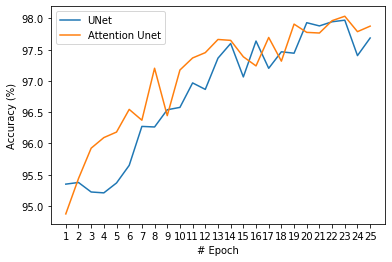

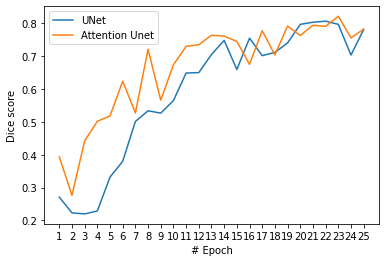

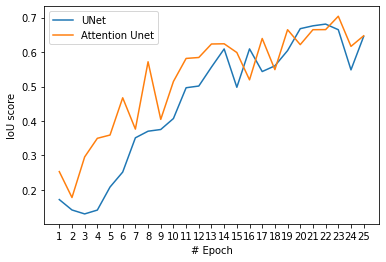

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(1, NUM_EPOCHS+1)

plt.plot(x, UNet_metrics["accuracy_scores"], label='UNet')
plt.plot(x, AttUNet_metrics["accuracy_scores"], label='Attention Unet')
plt.xticks(x)
plt.ylabel('Accuracy (%)')
plt.xlabel('# Epoch')
plt.legend()
plt.show()

plt.plot(x, UNet_metrics["dice_scores"], label='UNet')
plt.plot(x, AttUNet_metrics["dice_scores"], label='Attention Unet')
plt.xticks(x)
plt.ylabel('Dice score')
plt.xlabel('# Epoch')
plt.legend()
plt.show()

plt.plot(x, UNet_metrics["iou_scores"], label='UNet')
plt.plot(x, AttUNet_metrics["iou_scores"], label='Attention Unet')
plt.xticks(x)
plt.ylabel('IoU score')
plt.xlabel('# Epoch')
plt.legend()
plt.show()

# Example of predictions

In [21]:
load_checkpoint(torch.load(os.path.join(base_path, "AttUNet.pth.tar")), model)

=> Loading checkpoint


In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import draw_segmentation_masks

import torchvision.transforms.functional as F


def show(imgs):
  fig = plt.figure(figsize=(15, 5))

  for i in range(len(imgs)):
      fig.add_subplot(2, len(imgs), i+1)
      plt.imshow(ToPILImage()(imgs[i]))
      plt.axis("off")
  
  plt.tight_layout()
  plt.show()

 ## Comparison between true labels and predictions on validation set:

True labels:


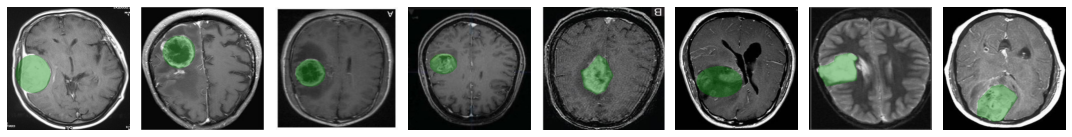

Predictions:


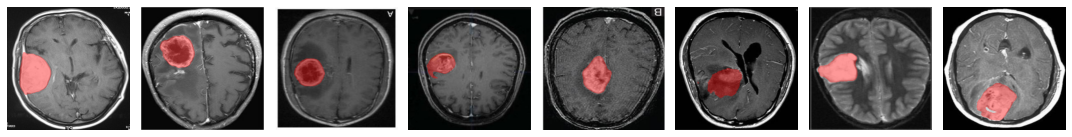

In [84]:
def showPredictions(loader, model):
  model.eval()
  with torch.no_grad():
    x, y = next(iter(loader))
    x = x.to(DEVICE)
    y = (y > 0.5)
    preds = torch.sigmoid(model(x))
    preds = (preds > 0.5)

    print("True labels:")
    imgs_with_masks = [draw_segmentation_masks((img*255).type(torch.cuda.ByteTensor).to("cpu"), masks=mask.to("cpu") , alpha=.4, colors="green") for img, mask in zip(x, y)]
    show(imgs_with_masks)

    print("Predictions:")
    imgs_with_masks = [draw_segmentation_masks((img*255).type(torch.cuda.ByteTensor).to("cpu"), masks=mask.to("cpu") , alpha=.4, colors="red") for img, mask in zip(x, preds)]
    show(imgs_with_masks)

showPredictions(valid_loader, model)

## Predictions on test set

In [22]:
def loadTestImg(image_dir, transform = None):
  images = os.listdir(image_dir)
  #print(images)
  index = np.random.randint(0, len(images) - 1)
  img_path = os.path.join(image_dir, images[index])

  image = np.array(Image.open(img_path).convert("RGB"))

  if transform is not None:
    augmentations = transform(image=image)
    image = augmentations["image"]
  
  return image

In [23]:
TEST_IMG_DIR_YES = os.path.join(TEST_IMG_DIR, "yes")
TEST_IMG_DIR_NO = os.path.join(TEST_IMG_DIR, "no")

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import draw_segmentation_masks

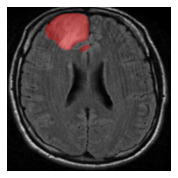

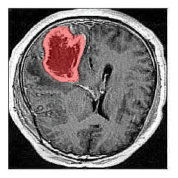

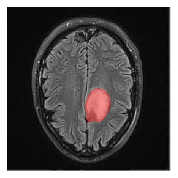

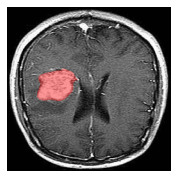

In [75]:
model.eval()
with torch.no_grad():
  imgs = []
  preds = []
  for i in range(4):
    img = loadTestImg(TEST_IMG_DIR_YES, test_transform)
    img = img.to(DEVICE).unsqueeze(0)

    pred =  torch.sigmoid(model(img))
    pred = (pred > 0.5)
  
    imgs_with_masks = [draw_segmentation_masks((img*255).type(torch.cuda.ByteTensor).to("cpu"), masks=mask.to("cpu") , alpha=.4, colors="red") for img, mask in zip(img, pred)]
    show(imgs_with_masks)

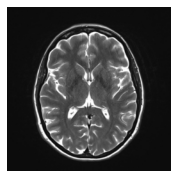

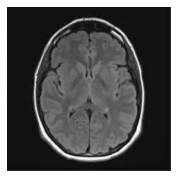

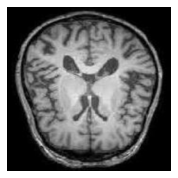

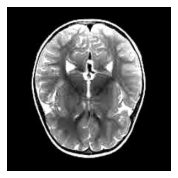

In [58]:
model.eval()
with torch.no_grad():
  imgs = []
  preds = []
  for i in range(4):
    img = loadTestImg(TEST_IMG_DIR_NO, test_transform)
    img = img.to(DEVICE).unsqueeze(0)

    pred =  torch.sigmoid(model(img))
    pred = (pred > 0.5)
  
    imgs_with_masks = [draw_segmentation_masks((img*255).type(torch.cuda.ByteTensor).to("cpu"), masks=mask.to("cpu") , alpha=.4, colors="red") for img, mask in zip(img, pred)]
    show(imgs_with_masks)